# Spectral for Twilite and Image-Derived Input Functions

## Setup

In [1]:
# system functions that are always useful to have
import time, sys, os
from pprint import pprint

try:
    import numpy as np
    print("numpy is available")  # numpy is available; Jupyter linter has an issue with numpy
except ImportError:
    print("numpy is not available")
# import numpy as np 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


numpy is available


In [2]:
from PETUtilities import PETUtilities
from IOImplementations import BaseIO
from RBCPartition import RBCPartition
from InputFuncData import InputFuncData
from SpectralContext import SpectralContext

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# everything is decay corrected

kerndir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "kernels")
kern = os.path.join(kerndir, "kernel_hct=46.8.nii.gz")

fdgdir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "ses-20210421155709", "pet")
pet = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames_timeAppend-165-ParcSchaeffer-reshape-to-schaeffer-schaeffer.nii.gz")

# no deconv., decay corrected, no recovery coefficient
idif_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif.nii.gz")
# deconv., decay corrected, no recovery coefficient
idif_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-MipIdif_idif-BoxcarIO-ideal.nii.gz")
idif = InputFuncData.nii_hstack(idif_deconv, idif_embed, t_crossover=300, output_format="fqfn")

# no deconv., decaying, measurements corrected to draw-times
twil_embed = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-embed.nii.gz")
# deconv., decaying, measurements corrected to draw-times, duration ~ 470 sec
twil_deconv = os.path.join(fdgdir, "sub-108293_ses-20210421155709_trc-fdg_proc-TwiliteKit-do-make-input-func-nomodel_inputfunc-RadialArteryIO-ideal.nii.gz")
twil = InputFuncData.nii_hstack(twil_deconv, twil_embed, t_crossover=300, output_format="fqfn")
twil = InputFuncData.decay_correct(twil, output_format="fqfn")

codir = os.path.join(os.getenv("HOME"), "PycharmProjects", "dynesty", "idif2025", "data", "ses-20210421144815", "pet")
v1_idif = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-idif_martinv1.nii.gz")
v1_twil = os.path.join(codir, "sub-108293_ses-20210421144815_trc-co_proc-delay0-BrainMoCo2-createNiftiMovingAvgFrames-ParcSchaeffer-reshape-to-schaeffer-schaeffer-twilite_martinv1.nii.gz")

parc_index = 25  # caudate ~ 26 (Matlab); thalamus ~ 6, 25 (Matlab)

RBCPartition t_crossover: 35


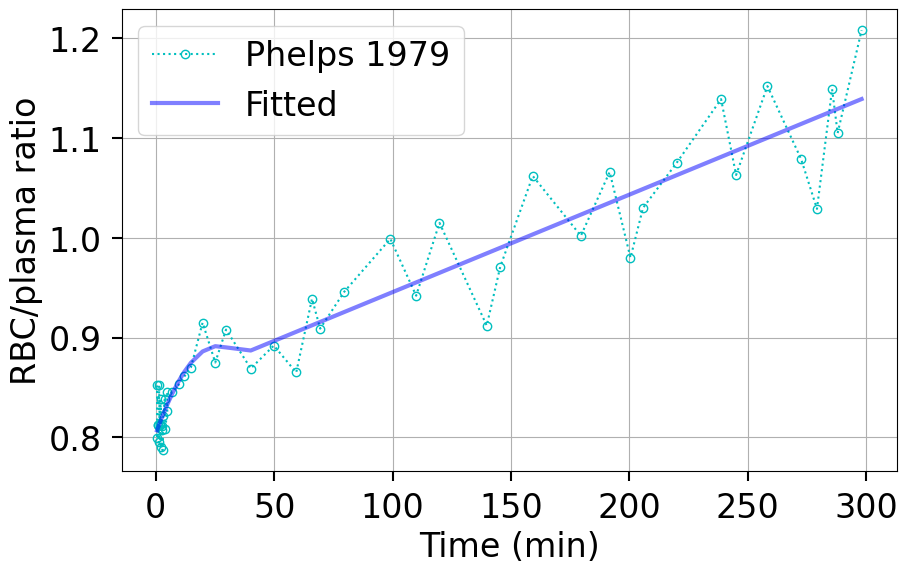

In [4]:
rbcp = RBCPartition(hct=46.8)
print(f"RBCPartition t_crossover: {rbcp.t_crossover}")
rbcp.plot()

## Inspect SpectralContext twil

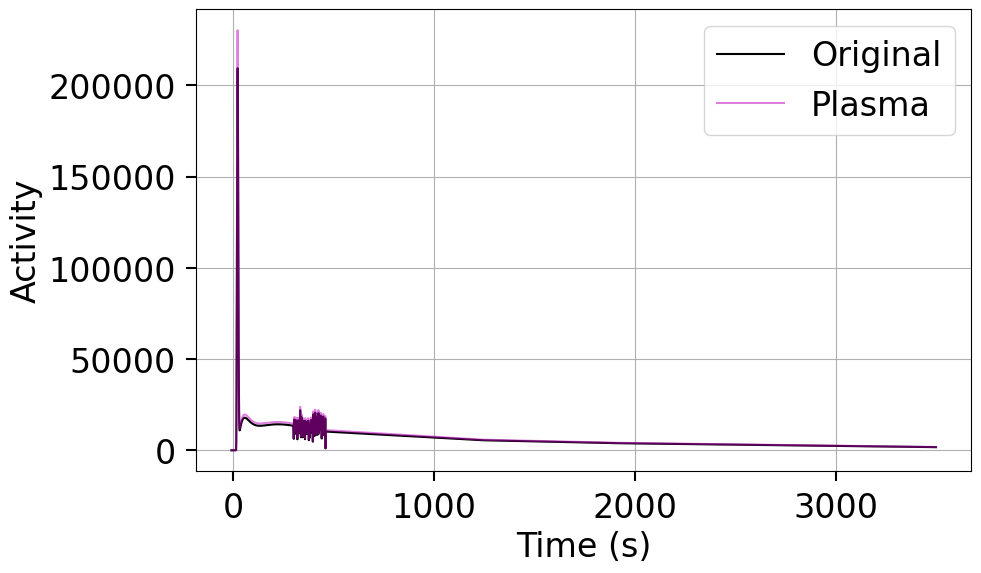

(474,)
'AUC: 22796288.208033822'


In [5]:
twil0 = BaseIO().nii_load(twil)
twil1 = rbcp.nii_wb2plasma(twil, output_format="niid")
twilp = rbcp.nii_wb2plasma(twil, output_format="fqfn")
plt.figure(figsize=(10,6))
plt.plot(twil0["timesMid"], twil0["img"], 'k-', label='Original')
plt.plot(twil1["timesMid"], twil1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

pprint(twil1["img"].shape)
auc = np.trapezoid(twil1["img"], twil1["timesMid"])
pprint(f"AUC: {auc}")

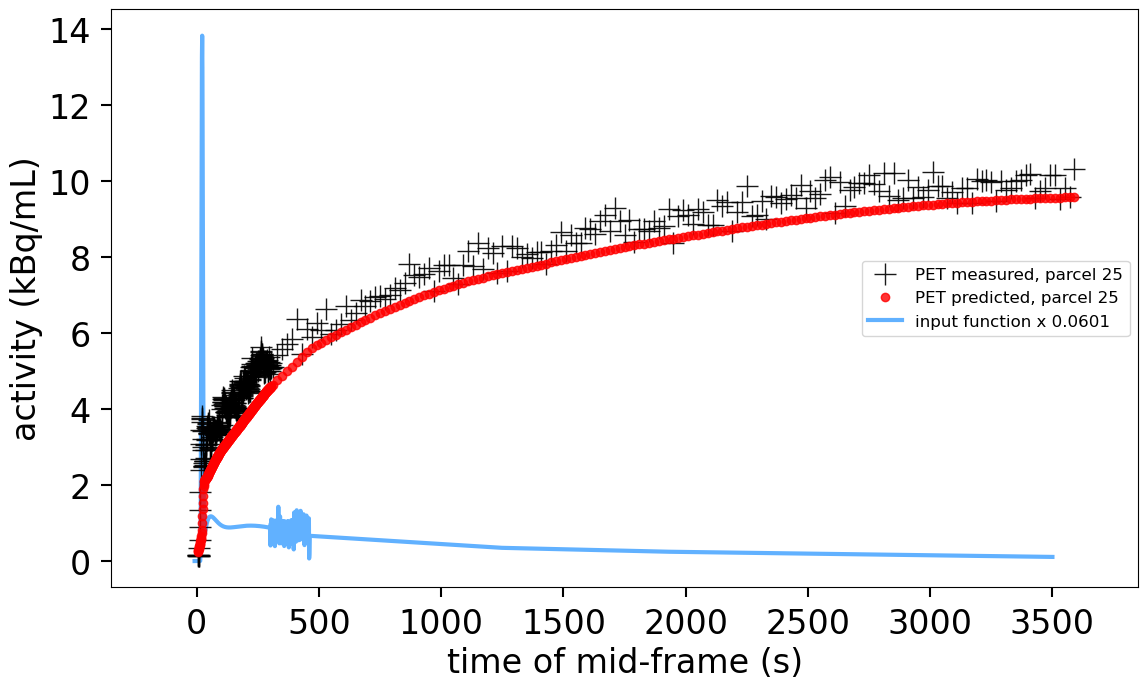

In [6]:
data_dict_twil = {
    "kernel_fqfn": kern,
    "input_func_fqfn": twilp,
    "tissue_fqfn": pet,
    "M": 2,
    "delta_time": 3,
    "nlive": 100,
    "tag": "playground_Spectral_twil"
}
truth_Spectral_twil = [    
    4.74044313e-04, 3.53960950e-03, 4.14853017e-04, 4.41882839e-05,
       2.30003700e-05, 1.98375048e+01, 2.46563851e-02
]
Spectral_twil = SpectralContext(data_dict_twil)
Spectral_twil.plotting.truths_plot(truths=truth_Spectral_twil, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [7]:
res_twil = Spectral_twil.solver.run_nested(print_progress=True, parc_index=parc_index)

24062it [44:00,  9.11it/s, batch: 17 | bound: 138 | nc: 1 | ncall: 1290045 | eff(%):  1.865 | loglstar:   -inf < 1182.644 < 1180.939 | logz: 1134.556 +/-  0.230 | stop:  0.923]              


DynestyPlotting.results_plot.dyplot.runplot: caught a ValueError: Axis limits cannot be NaN or Inf


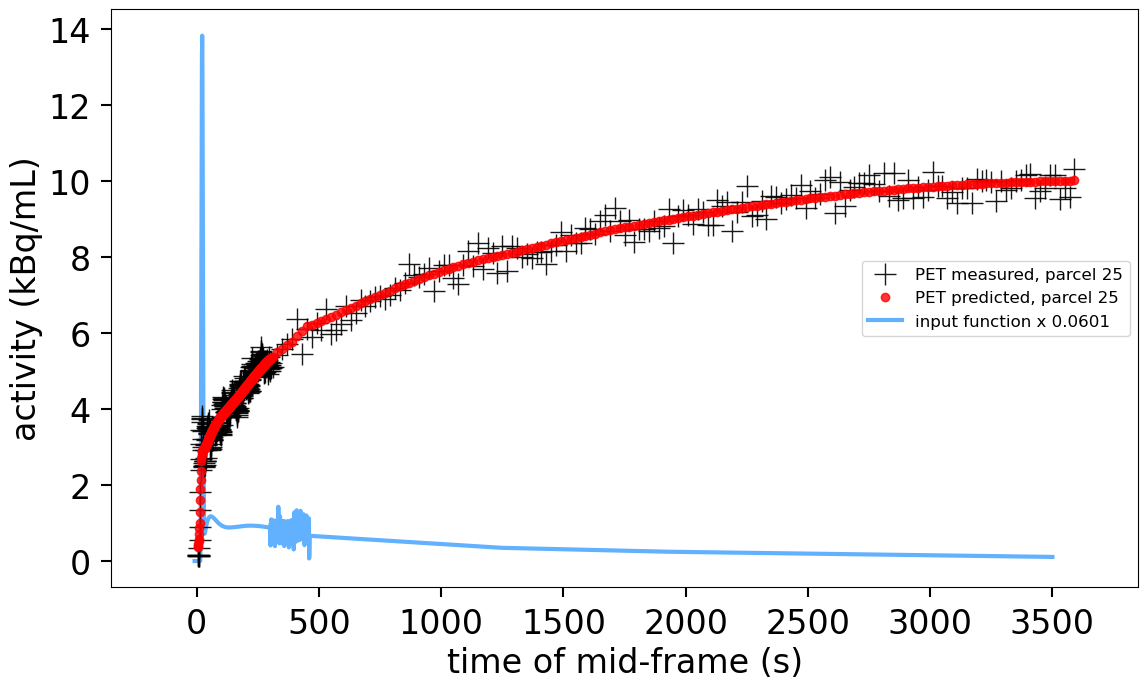

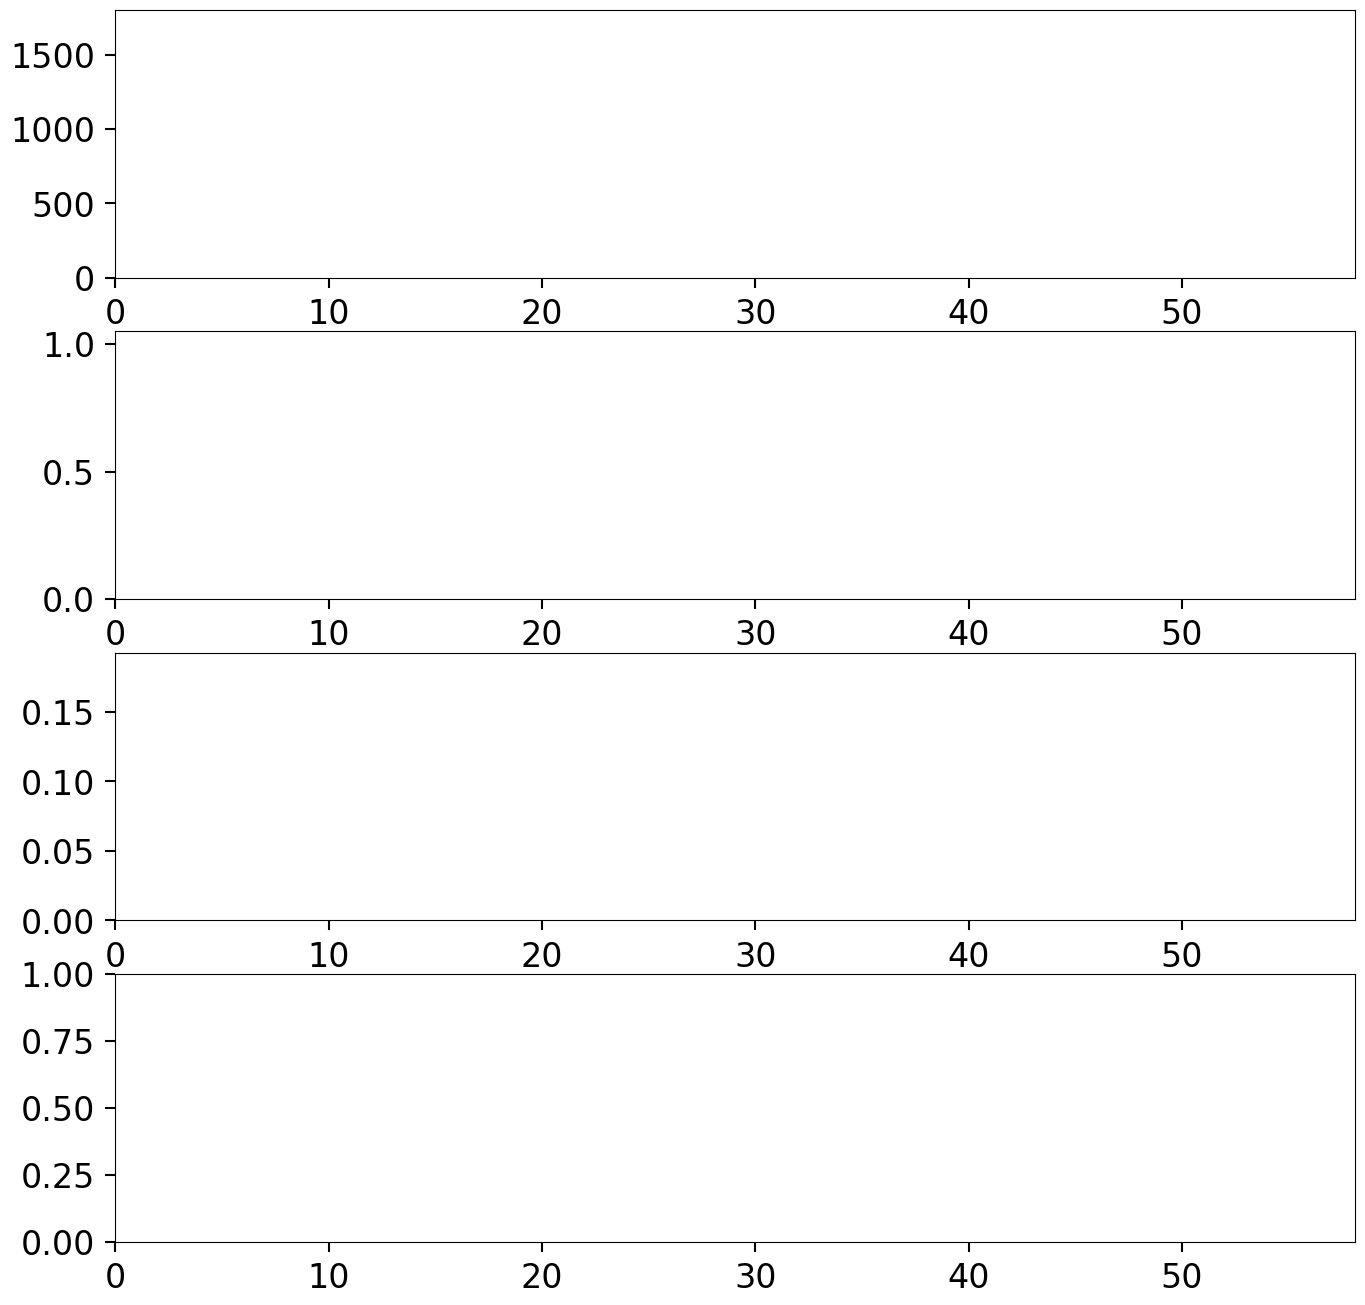

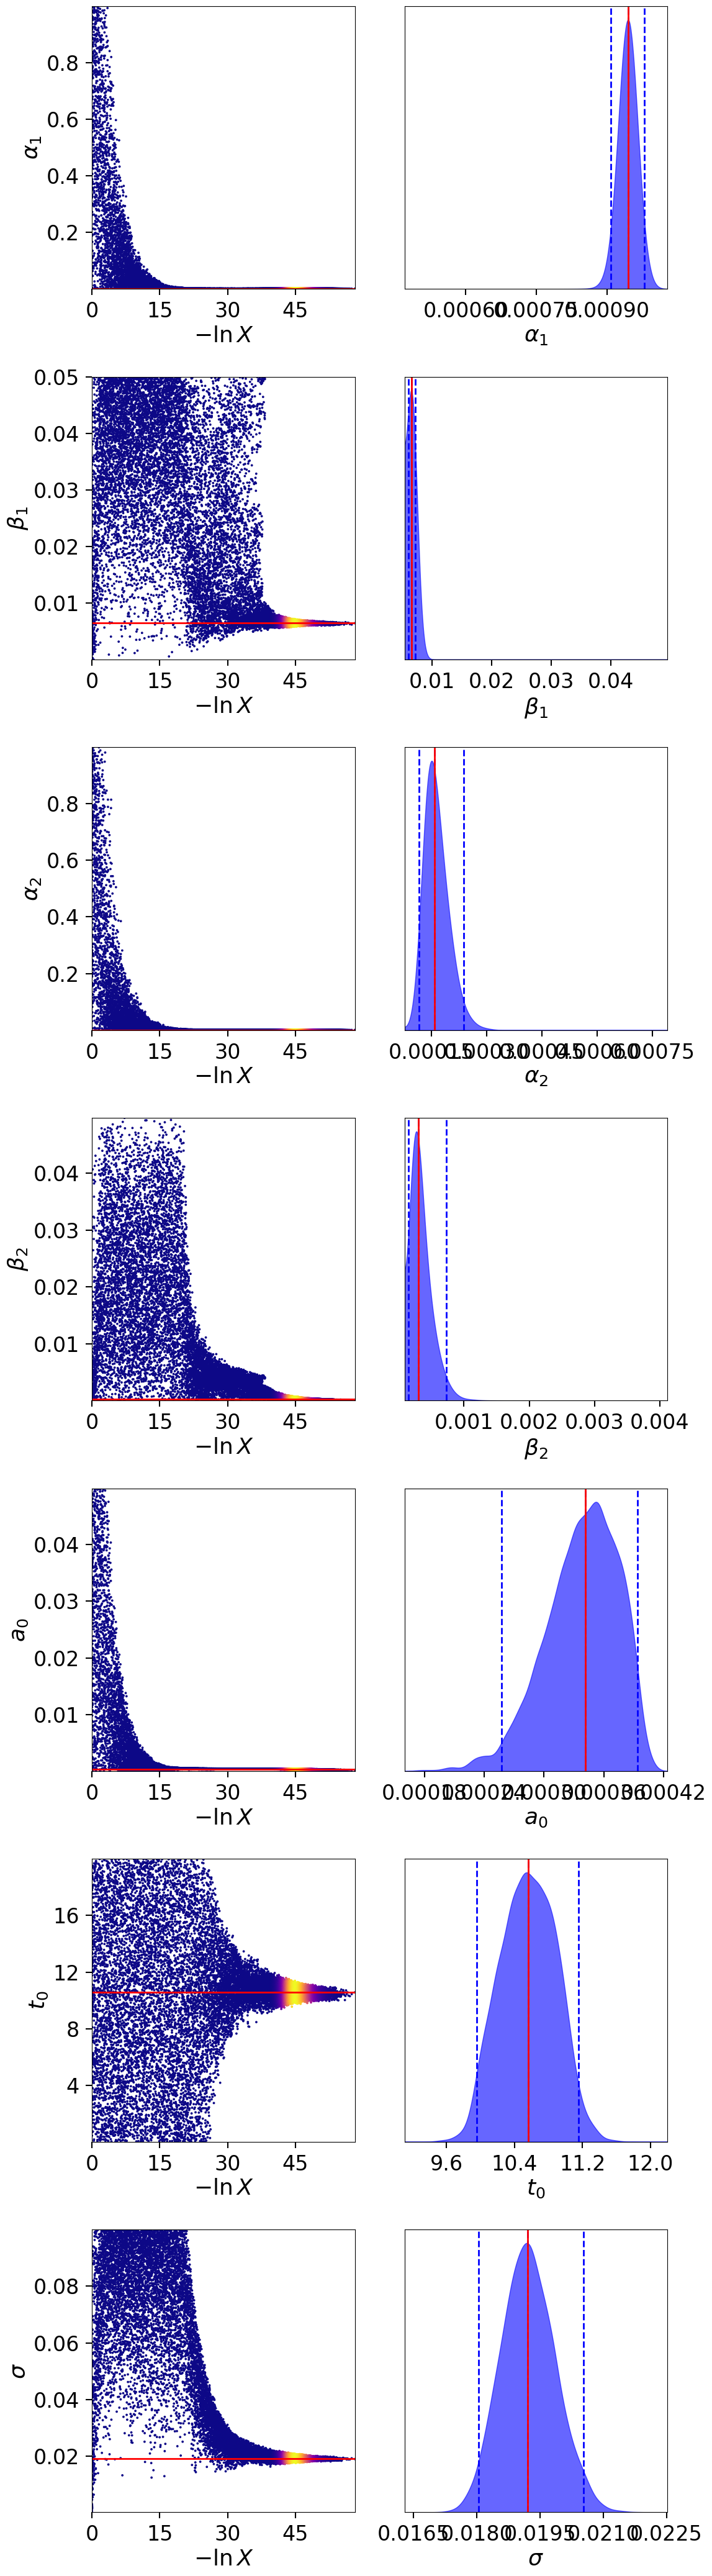

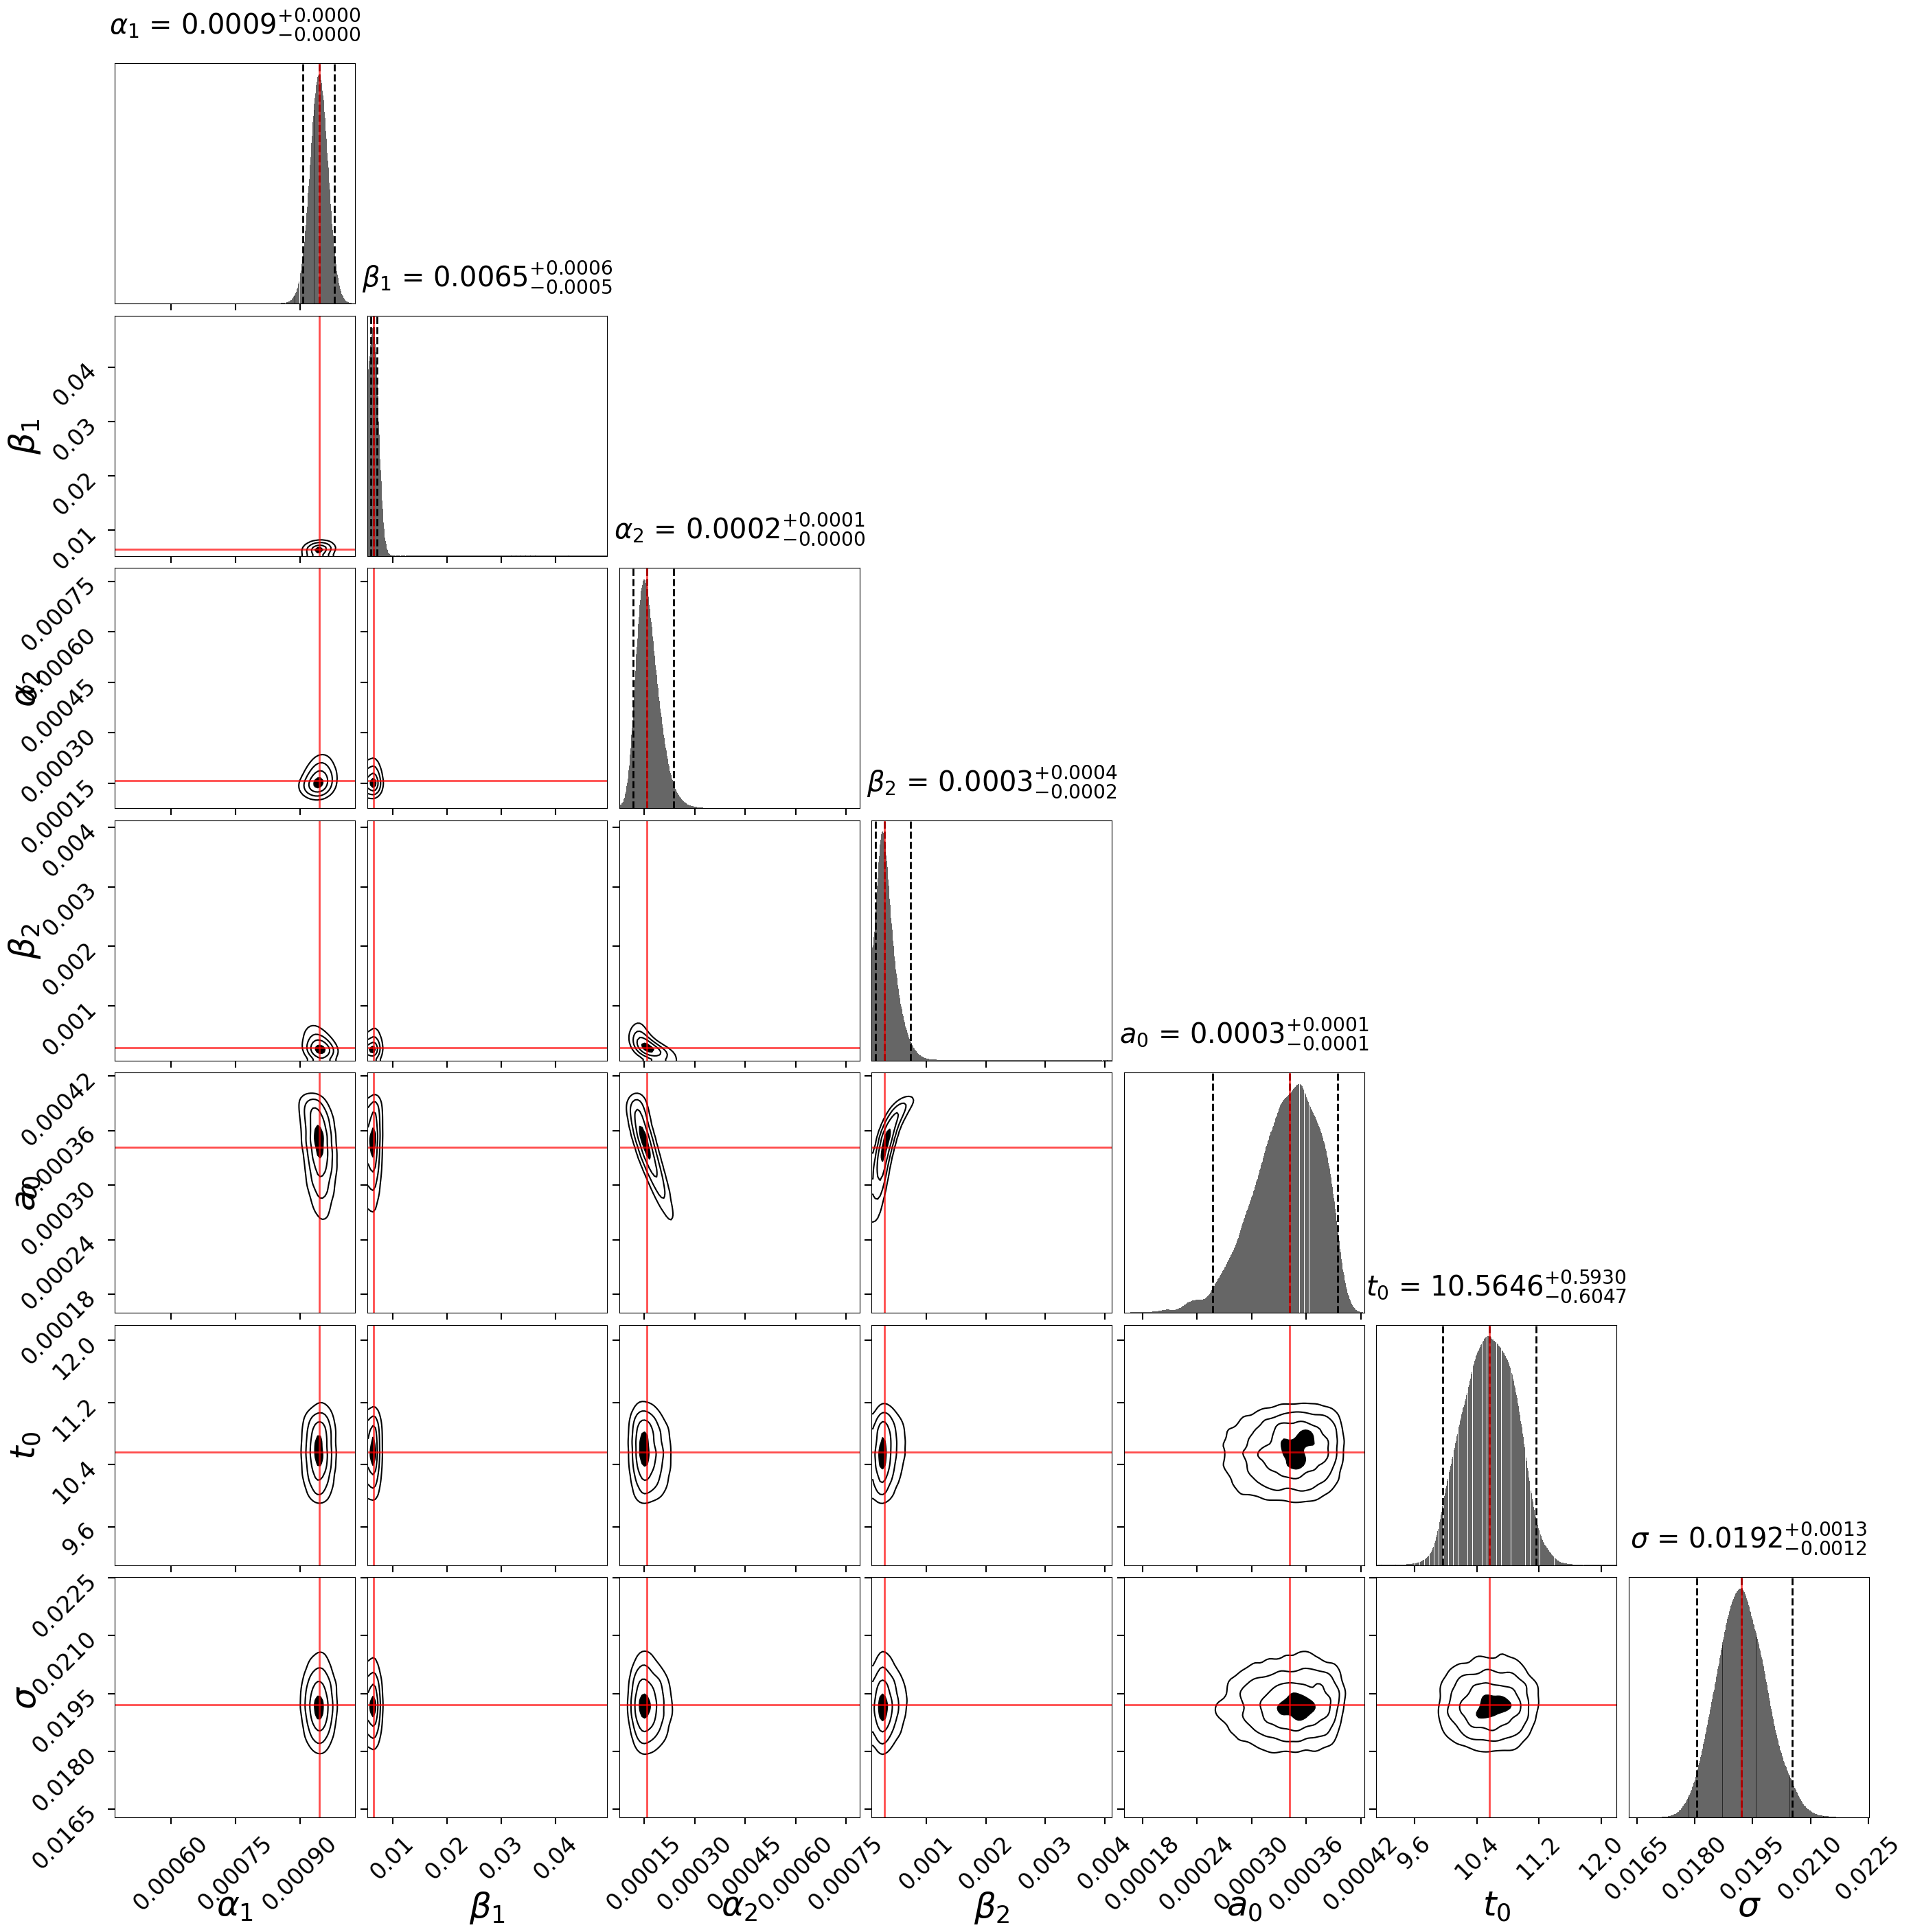

In [8]:
Spectral_twil.plotting.results_plot(tag="playground_Spectral_twil", parc_index=parc_index)

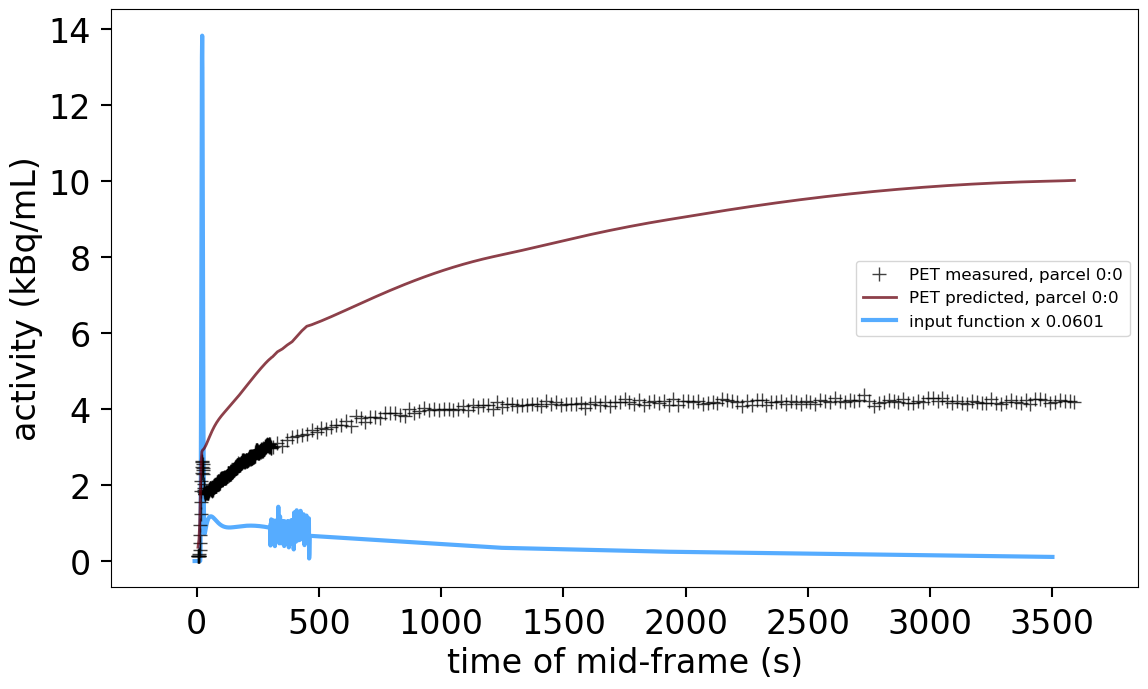

In [9]:
Spectral_twil.plotting.parcs_plot()

## Inspect SpectralContext idif

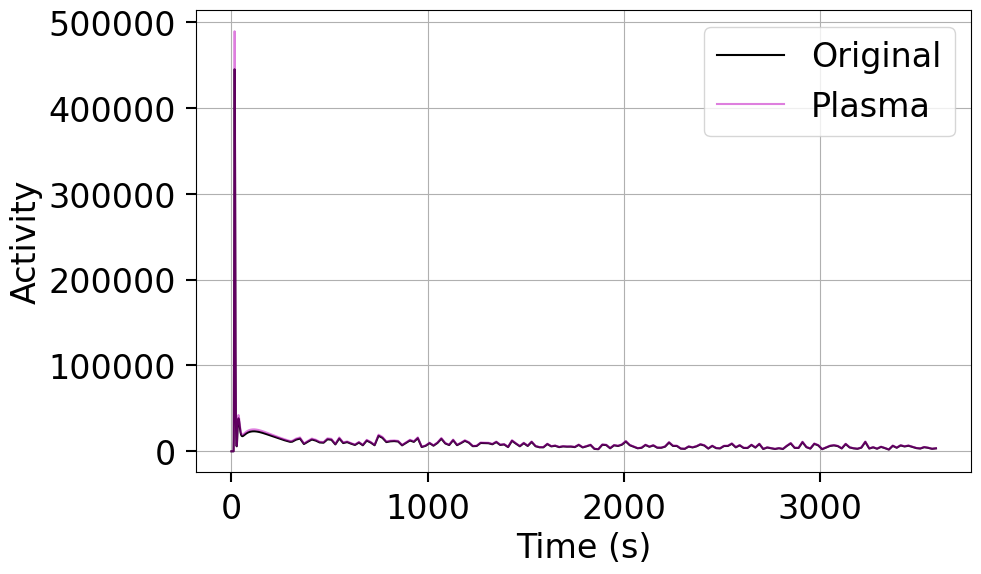

(465,)
'AUC: 18233441.47053301'


In [10]:
idif0 = BaseIO().nii_load(idif)
idif1 = rbcp.nii_wb2plasma(idif, output_format="niid")
idifp = rbcp.nii_wb2plasma(idif, output_format="fqfn")
plt.figure(figsize=(10,6))
plt.plot(idif0["timesMid"], 1.8509 * idif0["img"], 'k-', label='Original')
plt.plot(idif1["timesMid"], 1.8509 * idif1["img"], 'm-', alpha=0.5, label='Plasma')
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.grid(True)
plt.legend()
plt.show()

pprint(idif1["img"].shape)
auc = np.trapezoid(idif1["img"], idif1["timesMid"])
pprint(f"AUC: {auc}")

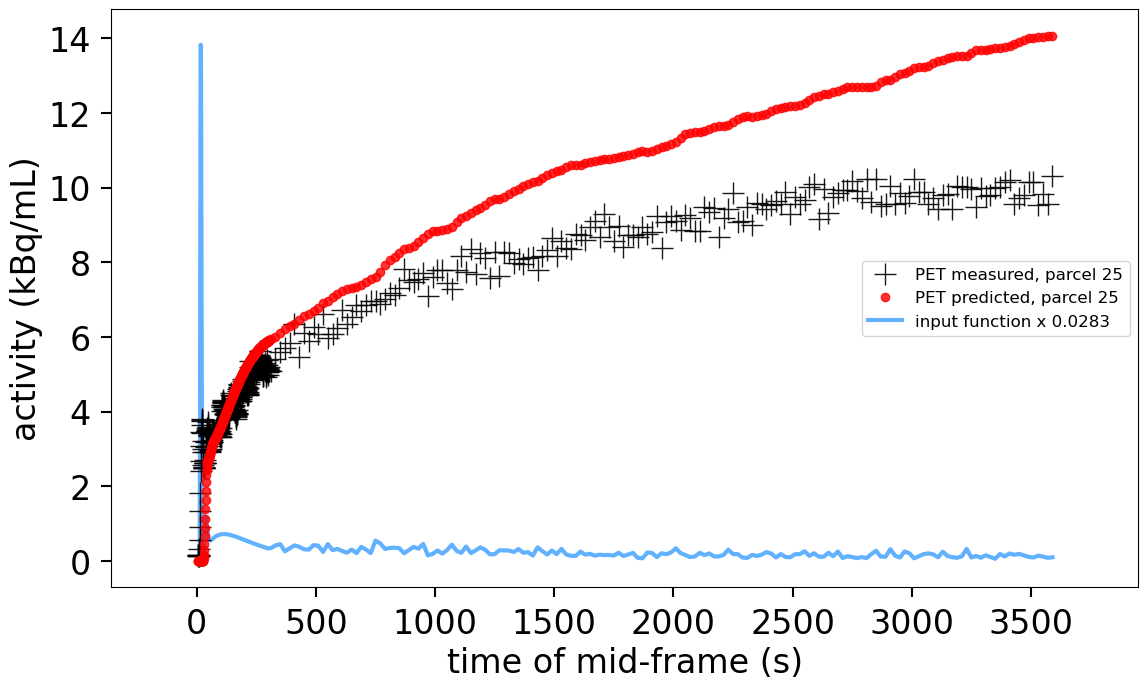

In [11]:
data_dict_idif = {
    "input_func_fqfn": idifp,
    "tissue_fqfn": pet,
    "M": 2,
    "delta_time": 3,
    "nlive": 100,
    "tag": "playground_Spectral_idif"
}
truth_Spectral_idif = [
    4.74044313e-04, 3.53960950e-03, 4.14853017e-04, 4.41882839e-05,
       2.30003700e-05, 1.98375048e+01, 2.46563851e-02
]

Spectral_idif = SpectralContext(data_dict_idif)
Spectral_idif.plotting.truths_plot(truths=truth_Spectral_idif, parc_index=parc_index)

Let's sample from this distribution using the default `dynesty` settings with `'slice'`.

In [12]:
res_idif = Spectral_idif.solver.run_nested(print_progress=True, parc_index=parc_index)

19194it [32:33,  9.83it/s, batch: 18 | bound: 24 | nc: 1 | ncall: 1019311 | eff(%):  1.873 | loglstar: 1127.984 < 1141.297 < 1140.341 | logz: 1092.963 +/-  0.246 | stop:  1.000]             


DynestyPlotting.results_plot.dyplot.runplot: caught a ValueError: Axis limits cannot be NaN or Inf


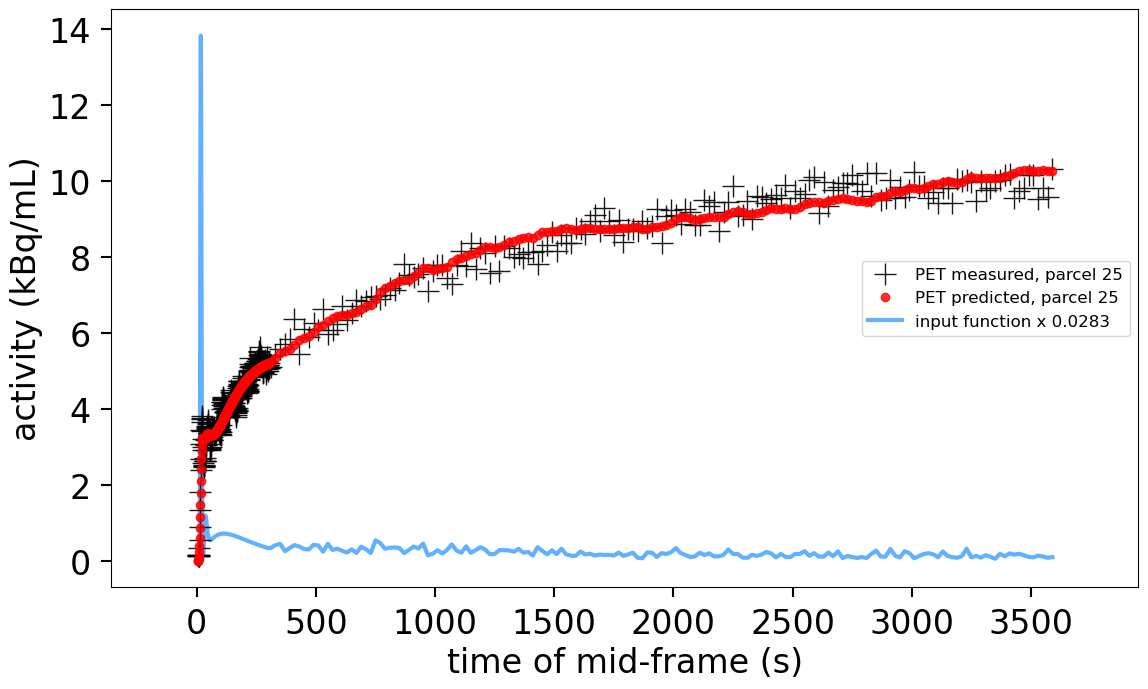

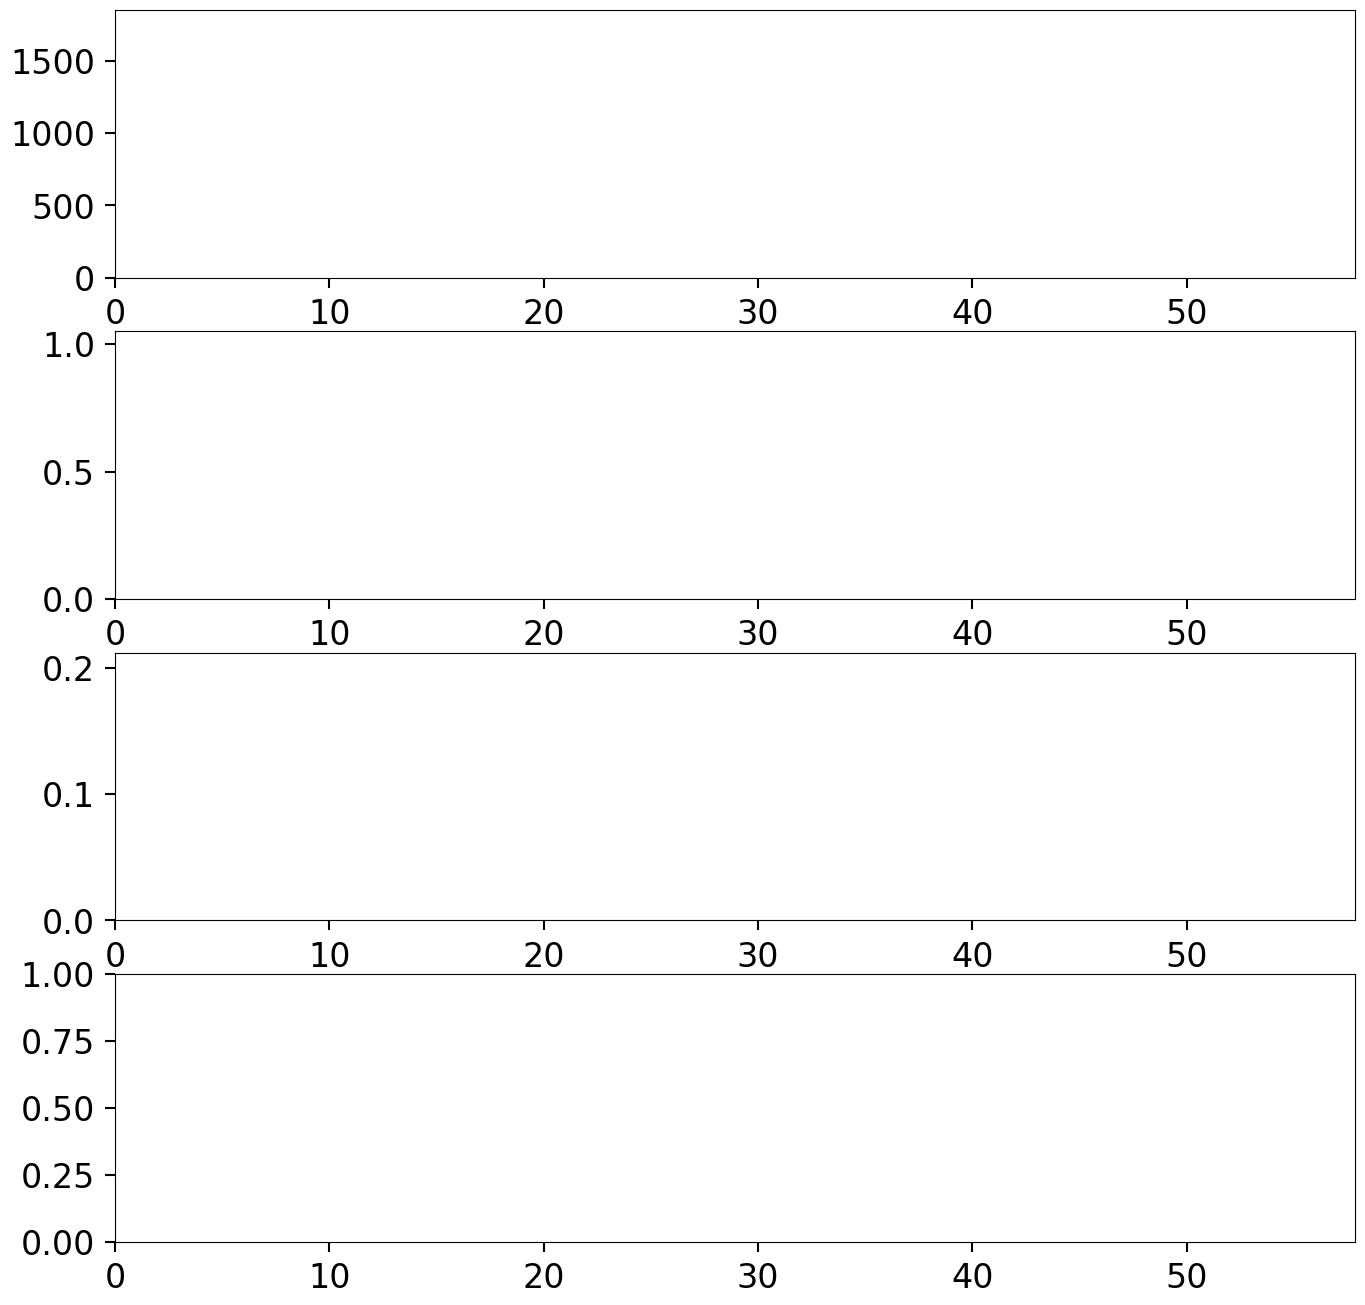

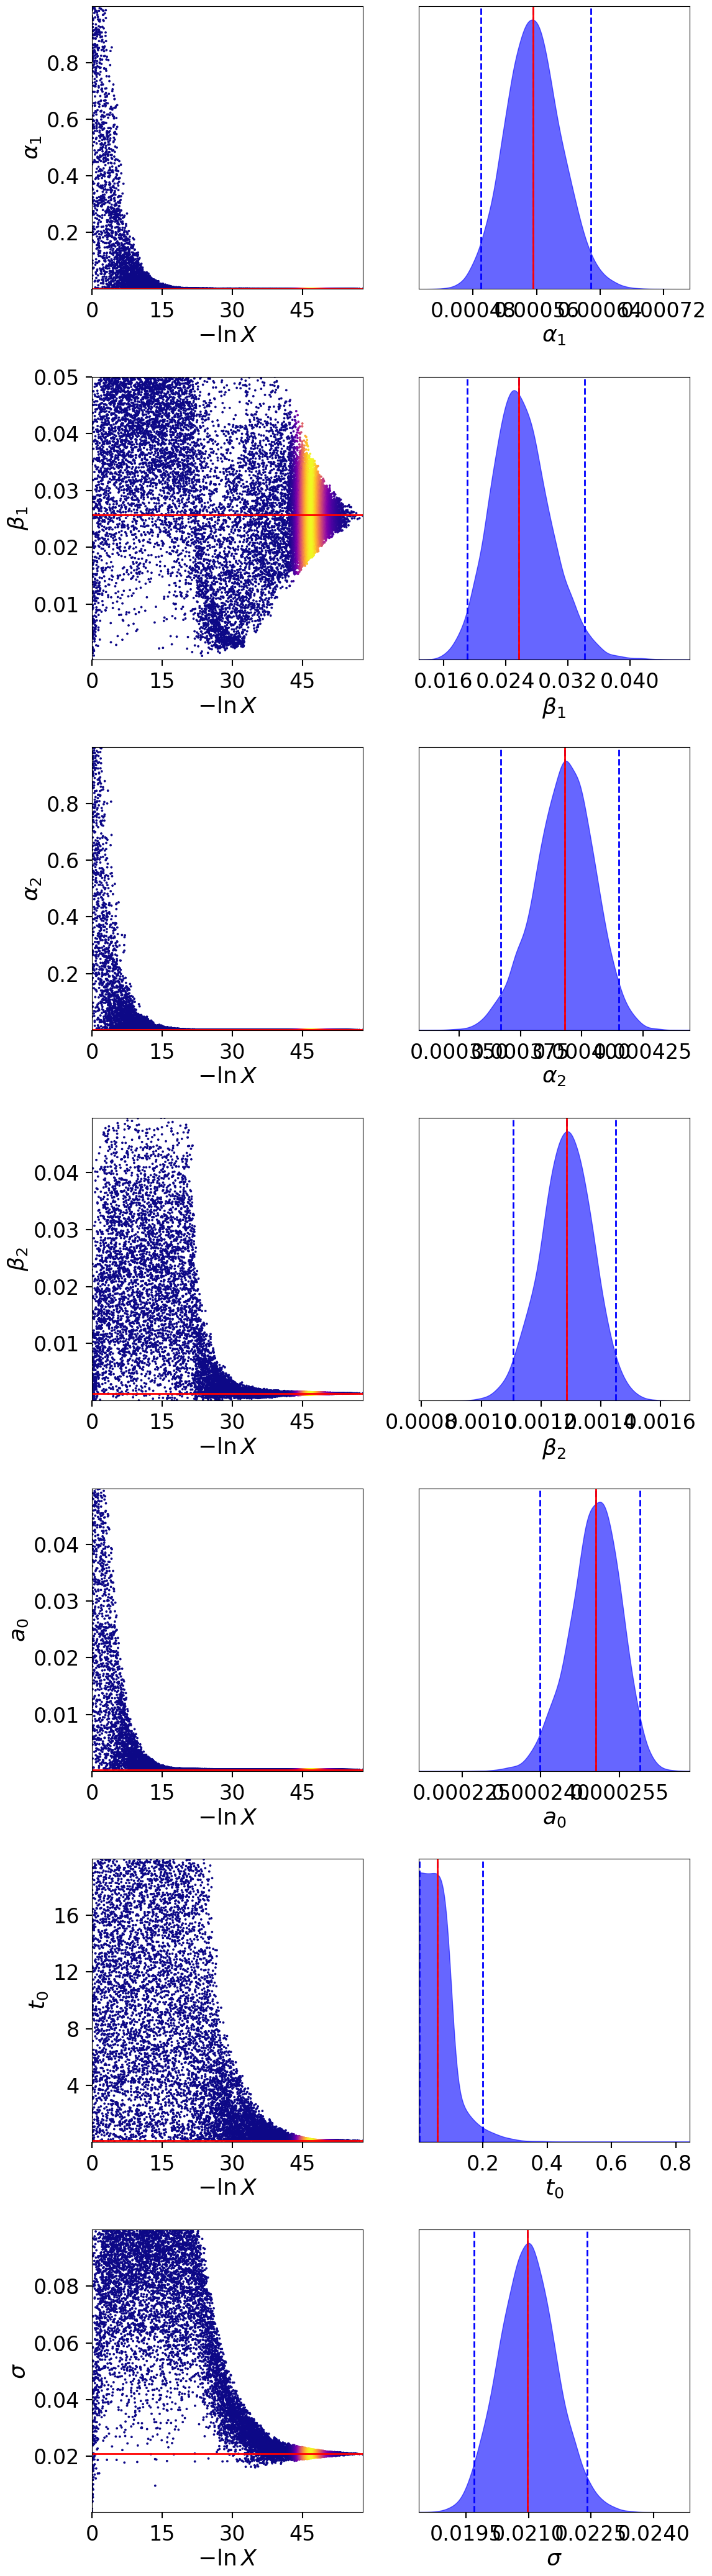

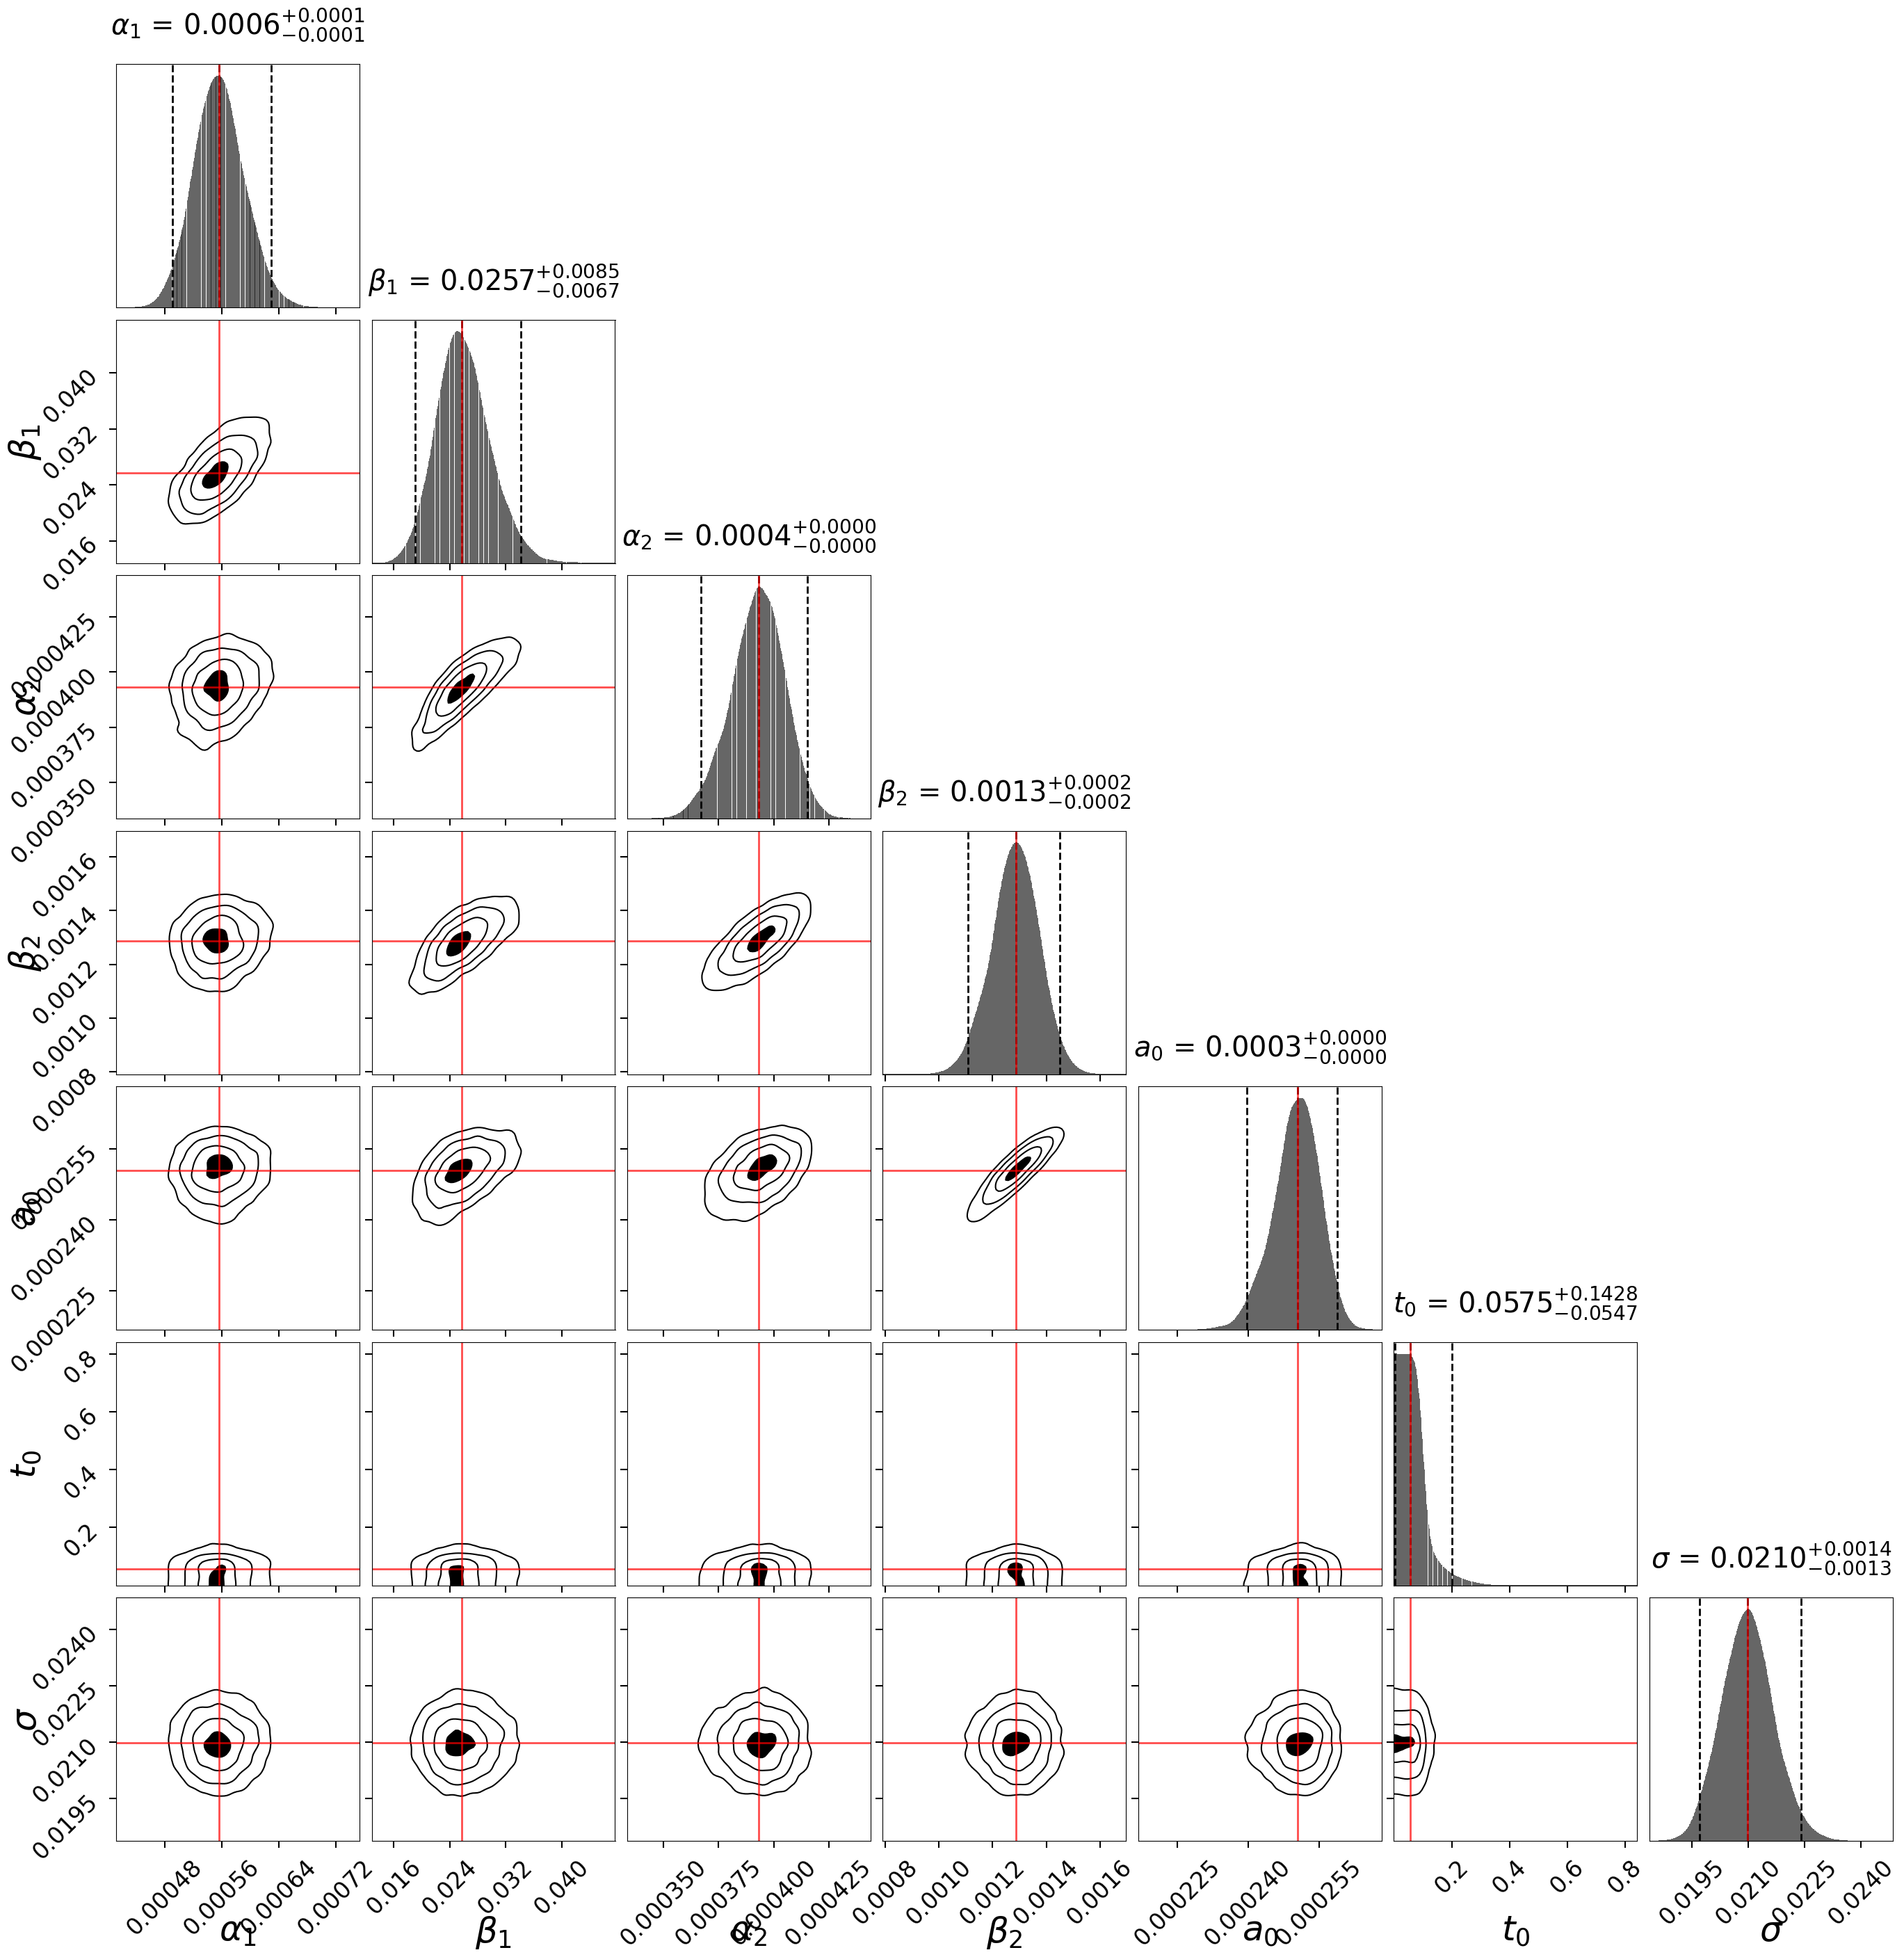

In [13]:
Spectral_idif.plotting.results_plot(tag="playground_Spectral_idif", parc_index=parc_index)

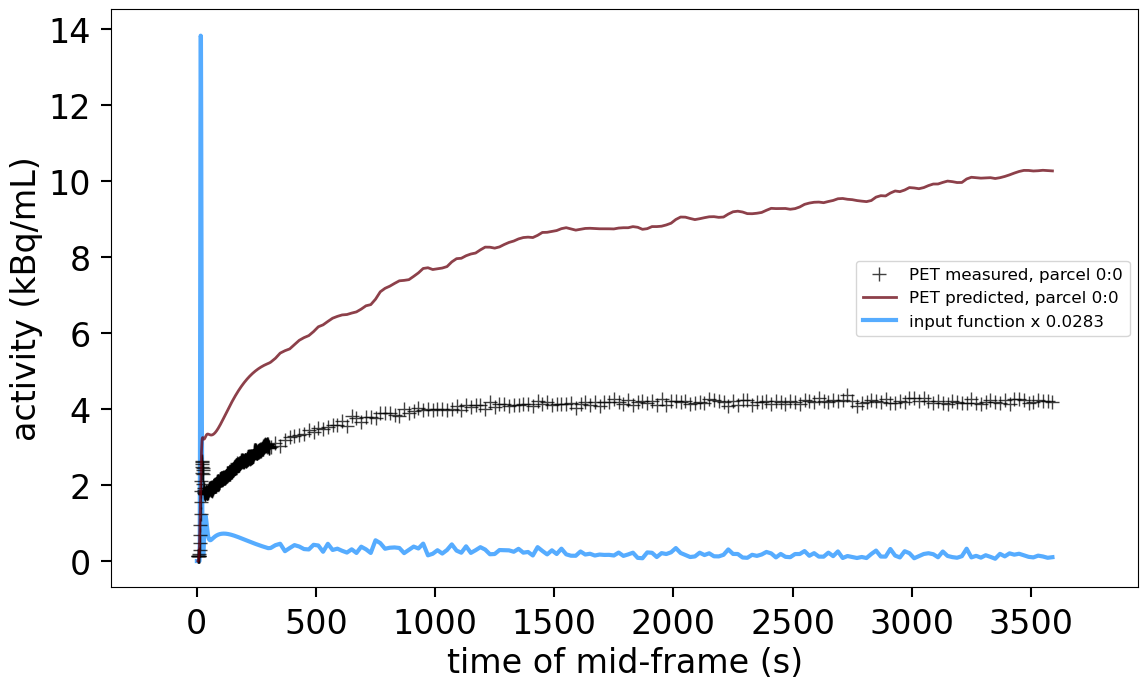

In [14]:
Spectral_idif.plotting.parcs_plot()

In [15]:
Spectral_twil.data.print_truths()
Spectral_idif.data.print_truths()



=============================== Truths ===============================
Parameter                        Value
----------------------------------------
$\alpha_{1}$                   0.00094
$\beta_{1}$                    0.00655
$\alpha_{2}$                   0.00016
$\beta_{2}$                    0.00030
$a_0$                          0.00034
$t_0$                         10.56463
$\sigma$                       0.01921


=============================== Truths ===============================
Parameter                        Value
----------------------------------------
$\alpha_{1}$                   0.00056
$\beta_{1}$                    0.02574
$\alpha_{2}$                   0.00039
$\beta_{2}$                    0.00129
$a_0$                          0.00025
$t_0$                          0.05751
$\sigma$                       0.02098


In [16]:
pprint(Spectral_twil.solver.truths)
pprint(Spectral_idif.solver.truths)

array([9.44014917e-04, 6.54783288e-03, 1.57511749e-04, 3.01992352e-04,
       3.41678808e-04, 1.05646267e+01, 1.92067070e-02])
array([0.00055537, 0.02573584, 0.00039315, 0.00128713, 0.00025051,
       0.05751188, 0.02098189])
